# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)


# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  Classify bitcoin addressess as 

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

#### 1.2.0 Variables:
---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Variables:

- The **address** is a public address (key) which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC)
<b>
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses:
<b>
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction
has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
address is an output address of a starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from any starter
transaction and ending at address $a$. he count feature represents
information on the number of transactions, whereas the weight
feature represents information on the amount (what percent of
these transactions’ output?) of transactions.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 

### 1.3 Packages and helper functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import pickle
import pdb
import datetime
import warnings

from scipy.stats import pearsonr
from scipy.stats import boxcox, yeojohnson


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = True
DS_FRAC = 1
NF = 5

In [4]:
def sigmoid(x):
    #returns the logistic function of x
    return 1 / (1 + np.exp(-x))

### 1.4 Importing data

In [6]:
df = pd.read_csv('BitcoinHeistData.csv')
df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE)
ROWS = df.shape[0]
COLS = df.shape[1]
ROWS,COLS

(2916697, 10)

In [7]:
# copy a data frame
dfc = df.copy()

In [8]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,577264100.0,white
2013400,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,100000000.0,white
2704440,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,299950000.0,white
1650833,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,299000000.0,white
1586811,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,40000000.0,white


In [9]:
remove_words = ["princeton","padua","montreal"]
for r in remove_words:
    dfc['label']=dfc['label'].str.replace(r,"")

In [10]:
years = df['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File containts {:d} rows and {} columns'.format(df.shape[0], df.shape[1]))


The data extends from 2011 to 2018.
File containts 2916697 rows and 10 columns


In [11]:
features=list(df.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [12]:
print('Datatypes: \n\n{}'.format(df.dtypes))

Datatypes: 

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object


In [13]:
top_ransomwares_dict = dict(dfc.label.value_counts().head(10)[1:])
top10_ransoms_labels = dfc.label.value_counts()[1:11]
top10_ransoms_labels

CryptoWall             12390
CryptoLocker            9315
Cerber                  9223
Locky                   6625
CryptXXX                2419
NoobCrypt                483
DMALockerv3              354
DMALocker                251
SamSam                    62
CryptoTorLocker2015       55
Name: label, dtype: int64

- Note that the data is highly unbalanced

In [14]:
print('The data is over 95% unbalanced towards clean!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(df['label'].value_counts()[0], 
        sum(df['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean!

white label cnt: 2875284
rannsomware label cnt: 41413


We have a large proportion of white points to ransom points

### 1.5 Cleaning the data

- check for corrupted, missing, or duplicated entries

In [15]:
df.isnull().any() # check for null values

address      False
year         False
day          False
length       False
weight       False
count        False
looped       False
neighbors    False
income       False
label        False
dtype: bool

In [16]:
print('The data is free of obvious null values')

The data is free of obvious null values


In [17]:
df = df.drop_duplicates() # if any

### 1.6 X,y split of the data

In [18]:
def labels_to_binary(df_labels):
    # takes labels of df and makes them binary
    
    labels = np.array([])
    
    for label_i in tqdm(df_labels):
        if label_i == 'white':
            # label all presumed "white" addresses with 0
            labels = np.append(labels, 0) 
        else:
            # label all ransomware addresses with 1
            labels = np.append(labels, 1) #ransomware
    return labels

In [19]:
labels = labels_to_binary(df.label) # labels array

  0%|          | 0/2916697 [00:00<?, ?it/s]

In [20]:
labels_df = pd.DataFrame(labels,columns=['labels'])

In [21]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (sum(labels) / len(labels)) * 100) )

Percentage of labels belonging to ransomware class: 1.4


**Defining {X, X_test, x_rain, y_test, y_train}**

In [22]:
X_df = df.drop(['label'],axis=1) # features original

In [23]:
# WORKING test train split. We perform many operations on this data
# We will down sample this data for plotting, testing, and training optimization
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    #df.drop(['label'], axis=1), # X
    labels_df,                   # y 
    stratify = labels,          # We stratify to preserve the large imbalance in the target variable
    random_state = RAND_STATE,
    test_size = SPLIT_RATIO
)

In [24]:
fname = 'X_train_y_train_X_test_y_test_0'+str(NF)+'.pickle'

In [25]:
if SAVE_TEST_TRAIN == True: 
    with open(fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)


In [26]:
# copy original dataframes to compare lates (background)
X_orig = X_df.copy()
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

# 2.0 Feature Analysis

* Transform features to reduce their skew
* Normalize to unit variance and zero mean for distance classification
* Engineer new features from the old ones

## 2.1 Feature Distributions, Normalization, and Engineering

* Description goes here

In [27]:
pt = PowerTransformer(method='box-cox') # boxcox power transformer

In [28]:
def plot_pdf(df, col):
    sns.distplot(df[col])
    plt.title(str(col) +  ' distribution')
    plt.ylabel('density')
    plt.xlabel(col)
    plt.plot()

In [29]:
def apply_pt_for_plots(df_,col_):
    return pt.fit_transform(np.array(df_[col_]).reshape(-1,1))

In [30]:
def apply_box(df_,col_):
    return  boxcox(np.array(df_[col_]))[0] 
def apply_yeo(df_,col_):
    return  yeojohnson(np.array(df_[col_]))[0] 

#### 2.1.0 income , bc_income

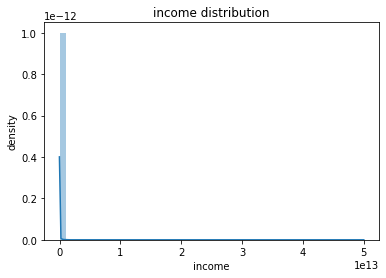

In [31]:
plot_pdf(X_train,'income')

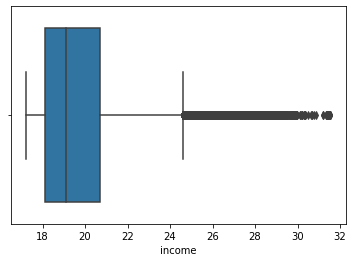

In [32]:
#plotting box plots
ax = sns.boxplot(x=np.log(X_train['income']))

In [33]:
X_train.income.skew() # highly skwewed

223.74388442838963

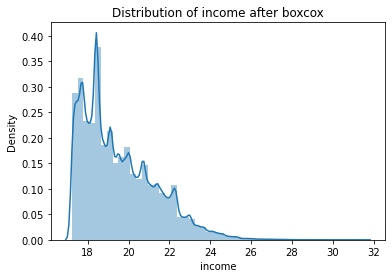

In [34]:
sns.distplot( np.log(X_train['income']) )
plt.title('Distribution of income after boxcox')
plt.show()

Log doesn't quite normalize the distribution. Try with boxcox

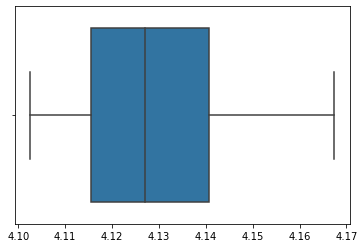

In [35]:
# plot box plot
ax = sns.boxplot(x=boxcox(X_train['income'])[0])

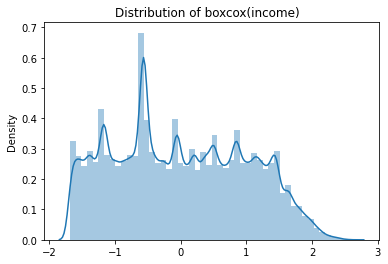

In [36]:
sns.distplot(apply_pt_for_plots(X_train,'income') )
plt.title('Distribution of boxcox(income)  ')
plt.show()

In [37]:
bc_income_train = apply_box(X_train, 'income')
bc_income_test = apply_box(X_test, 'income')
pd.Series(bc_income_train).skew(),pd.Series(bc_income_test).skew() # slightly skewed to the right  

(0.15762680795103856, 0.1580784865604138)

#### 2.1.1 day,  day_of_week

In [38]:
print('The mean number of entries per day is {:.2f}.'.format(X_df.day.mean()))

The mean number of entries per day is 181.46.


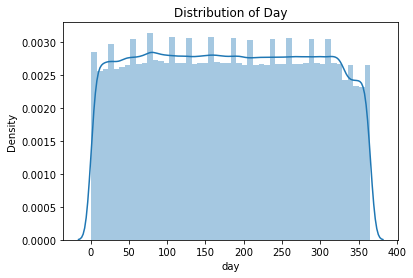

In [39]:
sns.distplot(X_train['day']) 
plt.title('Distribution of Day')
plt.show()

In [40]:
X_train.day.skew() # fairly normal. No transform needed

0.010502148010392898

###### Engineering day of week feature

In [41]:
def get_day_number(first_day_of_year, day):
    #return day number (0 for monday, 6 for sunday) for day
    return (first_day_of_year + day - 1) % 7

In [42]:
day_of_week_train = np.array([])
for index, row in tqdm(X_train.iterrows()):
    #For each data-point, we consider its year and day and calculate what day of the week (Monday, Tuesday, etc)
    #it was when the transaction happened

    #datetime.datetime(year, 1, 1).weekday() returns the first day of the year in the year = year
    #using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week_train = np.append(day_of_week_train, \
                                  get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [43]:
day_of_week_test = np.array([])
for index, row in tqdm(X_test.iterrows()):
    #same as above but for test set

    year_i, day_i = row['year'], row['day']
    day_of_week_test = np.append(day_of_week_test, \
                                 get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

####  2.1.2 length, bc_length

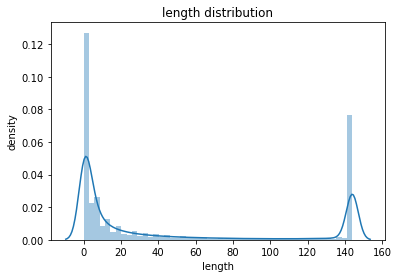

In [44]:
plot_pdf(X_train,'length')

In [45]:
X_train.length.skew(), np.sqrt(X_train['length']).skew(), \
pd.Series(np.log(np.sqrt(np.array(X_train['length']) + 1e-6))).skew()

(0.9254499020706156, 0.5753589017847328, -1.0738551331341115)

In [46]:
#constructing the feature

bc_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-8))))**2)[0]
bc_length_test  = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-8))))**2)[0]

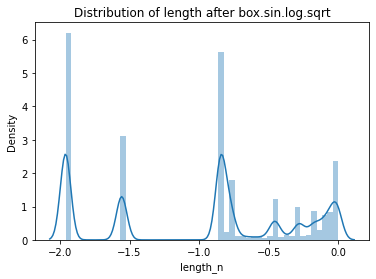

In [47]:
sns.distplot(bc_length_train)
plt.title('Distribution of length after box.sin.log.sqrt')
plt.xlabel('length_n')
plt.show()

In [48]:
pd.Series(bc_length_train).skew()

-0.1807390108634564

#### 2.1.3 weight, yeo_weight

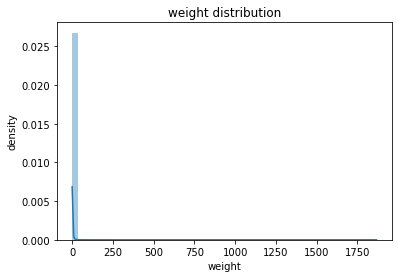

In [49]:
plot_pdf(X_train, 'weight')

In [50]:
X_train['weight'].describe()

count    2.245856e+06
mean     5.450332e-01
std      3.569671e+00
min      3.606469e-94
25%      2.147613e-02
50%      2.500000e-01
75%      8.868067e-01
max      1.866717e+03
Name: weight, dtype: float64

In [51]:
X_train.weight.skew() # very skewed

241.30528151192055

In [52]:
yeo_weight_train = yeojohnson(X_train.weight)[0] 
yeo_weight_test  = yeojohnson(X_test.weight)[0] 
pd.Series(yeo_weight_train).skew(), pd.Series(yeo_weight_test).skew()

(0.234994654528281, 0.23612532862797642)

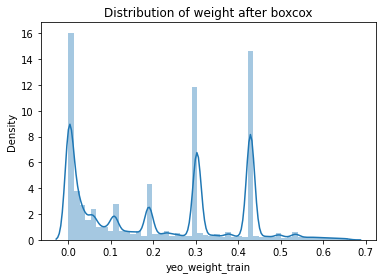

In [53]:
sns.distplot(yeo_weight_train)
plt.title('Distribution of weight after boxcox')
plt.xlabel('yeo_weight_train')
plt.show()

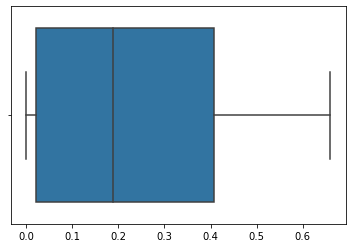

In [54]:
#plotting box plots
ax = sns.boxplot(x=yeo_weight_train)

#### 2.1.4 address, logbc_n_address

In [55]:
X_train['address'].value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    315
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    189
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    158
12YursV58dRT2c9iuZg3jEWfwgTDamBcnd    143
1CVWpTNwNYGdKgZRohiiVFrnFNbw8anG9     134
                                     ... 
163uHYykseq8RDPgQRcmzSHq3gNDL4xMeB      1
1CZNSZikGTLUTYuHwynhKJBnK4ov4udWXz      1
12efmrN9TsuxfihwEaLnVsdyrdkCg8UwUf      1
18S2dKK2mpZoariHQvcqBKRNPdKCaWDvMF      1
1AgiezDcp2Nb94Na5MaqSPmkM6P54b6D5C      1
Name: address, Length: 2044946, dtype: int64

##### Highest paid ransom address

In [56]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address.groupby('address').mean()

,year,day,length,weight,count,looped,neighbors,income
address,,,,,,,,
1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013.386139,181.930693,7.485149,1.324719,43.930693,0.019802,1.554455,4.791904e+09


In [57]:
worst_culprit_address.groupby('address')['looped'].max()

address
1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    2
Name: looped, dtype: int64

##### Feature engineering:  logbc_n_address_train
* the number of times the address appears (log boxcox transformation applied)

In [56]:
address_cnts = X_train['address'].value_counts()
print('An address is repeated an average of {:.3f} number of times'.format(np.mean(address_cnts)))

An address is repeated an average of 1.098 number of times


In [57]:
address_cnts.skew()

44.946475541236715

In [58]:
#Since this is an extremely skewed feature let's only visualize the 1st percentile points
one_percentile = np.percentile(address_cnts, 99)

n_addresses_1perc = np.array([element for element in address_cnts if element <= one_percentile])

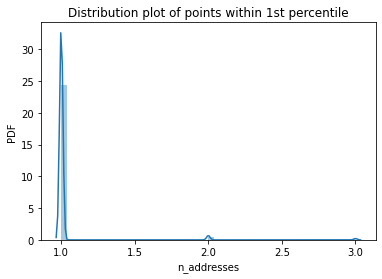

In [59]:
#checking points only within 1st percentile

plt.title('Distribution plot of points within 1st percentile')
sns.distplot(n_addresses_1perc)
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

In [60]:
dict_address_cnts = dict(X_train['address'].value_counts())
n_address = boxcox(np.array(list(dict_address_cnts.values())))[0]

# 
for index, key in tqdm(enumerate(dict_address_cnts.keys())):
    # updating the dictionary with number of times each address appears with the boxcox transformation applied to fix the skewness
    dict_address_cnts.update({key: address_cnts[index]})
 

0it [00:00, ?it/s]

In [61]:
address_n = boxcox(np.array(list(dict_address_cnts.values())))[0]
pd.Series(address_n).skew()

5.0474571130747465

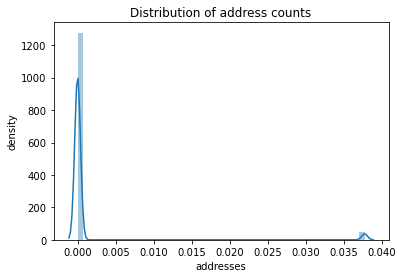

In [62]:
#plot to print distribution of n_addresses
plt.title('Distribution of address counts')
sns.distplot(address_n)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [63]:
bc_n_address_train = np.array([])

for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    #We are getting a list of the new values
    #For each address in the training set we are appending its corresponding boxcox'd
    #number of times its appeared in training set

    n_address_i = dict_address_cnts.get(X_train.loc[index]['address']) 
    bc_n_address_train = np.append(bc_n_address_train, n_address_i)

bc_n_address_test = np.array([])
min_dict_n_address = min(list(dict_address_cnts.values()))

for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    try:
        #we do the same as above
        n_address_i = dict_address_cnts[X_test.loc[index]['address']]
    except KeyError:
        #KeyError arises when the addreses in training set has not been seen before (i.e cold start)
        #For this, we assign the minimum value to it

        n_address_i = min_dict_n_address #Addressing cold start
    bc_n_address_test = np.append(bc_n_address_test, n_address_i)

  0%|          | 0/2245856 [00:00<?, ?it/s]

  0%|          | 0/670841 [00:00<?, ?it/s]

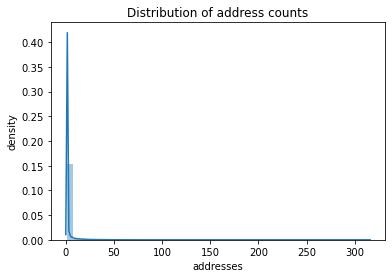

In [64]:
plt.title('Distribution of address counts')
sns.distplot(bc_n_address_train)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

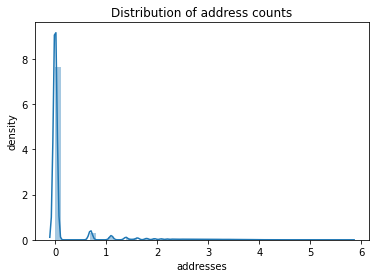

In [65]:
plt.title('Distribution of address counts')
sns.distplot(np.log(bc_n_address_train)) 
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [66]:
pd.Series( bc_n_address_train ).skew()

20.669142309836232

In [67]:
logbc_n_address_train= np.log(bc_n_address_train)
logbc_n_address_test= np.log(bc_n_address_test)

In [68]:
pd.Series( logbc_n_address_train ).skew()

3.680863126526104

#### 2.1.5 neighbors, bc_neighbors

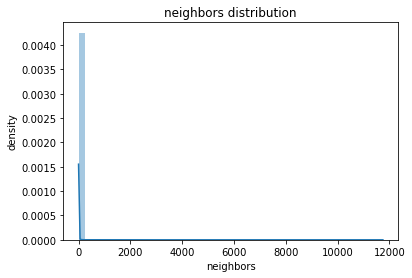

In [69]:
plot_pdf(X_train, 'neighbors')

In [70]:
bc_neighbors_train = apply_box(X_train,'neighbors')
bc_neighbors_test = apply_box(X_test,'neighbors')

#### 2.1.6 looped, sig_looped

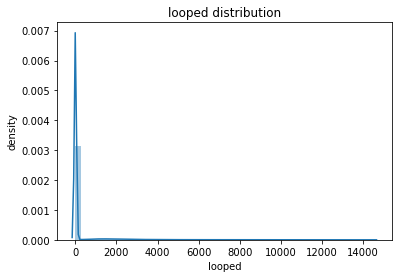

In [71]:
plot_pdf(X_train,'looped')

In [72]:
X_train.looped.skew()

5.524140639304542

In [73]:
pd.Series(sigmoid(np.array(X_train['looped']))).skew()

2.2179514248454013

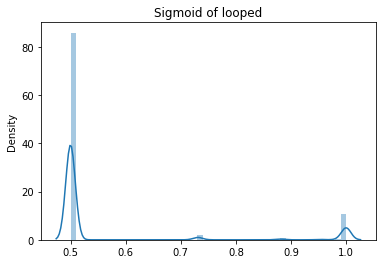

In [74]:
sns.distplot(sigmoid(np.array(X_train['looped'])))
plt.title('Sigmoid of looped')
plt.show()


In [75]:
sig_looped_train = sigmoid(np.array(X_train['looped']))
sig_looped_test = sigmoid(np.array(X_test['looped']))

In [76]:
pd.Series(sig_looped_train).skew()

2.2179514248454013

#### 2.1.7 count, log_count

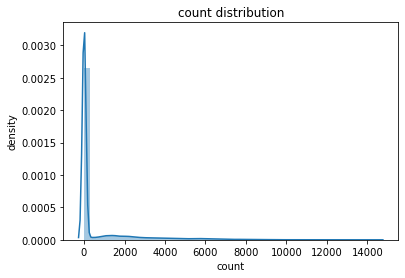

In [77]:
plot_pdf(X_train,'count')

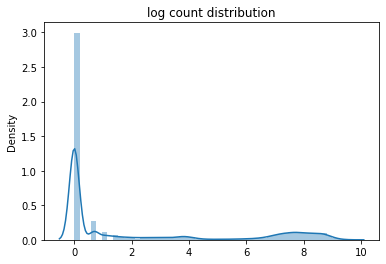

In [78]:
sns.distplot(np.log(np.array(X_train['count']) + 1e-6))
plt.title('log count distribution')
plt.show()

In [79]:
log_count_train = np.log(np.array(X_train['count']) + 1e-6)
log_count_test  = np.log(np.array(X_test['count'])  + 1e-6)

## 2.2 Standardizing,  Splitting, and Downsampling

* Data processing

#### 2.2.0 Inserting new features in X data

In [80]:
# original columns to get scaled for distance based classifiers
cols_orig = [ 
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income']
# new columns to get scaled for distance based classifiers
cols_new = [
    'bc_income',
    'bc_length',
    'yeo_weight',
    'logbc_n_address',
    'bc_neighbors',
    'sig_looped',
    'log_count',
    'day_of_week']

cols = cols_orig + cols_new
num_to_enc = 1

In [81]:
X_train['bc_income'] = bc_income_train
X_train['bc_length'] = bc_length_train
X_train['yeo_weight'] = yeo_weight_train
X_train['logbc_n_address'] = logbc_n_address_train
X_train['bc_neighbors'] = bc_neighbors_train
X_train['sig_looped'] = sig_looped_train
X_train['log_count'] = log_count_train
X_train['day_of_week'] = day_of_week_train

X_test['bc_income'] = bc_income_test
X_test['bc_length'] = bc_length_test
X_test['yeo_weight'] = yeo_weight_test
X_test['logbc_n_address'] = logbc_n_address_test
X_test['bc_neighbors'] = bc_neighbors_test
X_test['sig_looped'] = sig_looped_test
X_test['log_count'] = log_count_test
X_test['day_of_week'] = day_of_week_test


In [82]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [83]:
if SAVE_TEST_TRAIN == True:
    with open('derived'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

#### 2.2.1 Normalizing the data for distance based models

In [84]:
# cols to standardize (0 mean, unit variance)
col_names_standardize = cols[:-num_to_enc]
col_names_standardize

['year',
 'day',
 'length',
 'weight',
 'count',
 'looped',
 'neighbors',
 'income',
 'bc_income',
 'bc_length',
 'yeo_weight',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count']

In [85]:
# cols to encode

col_names_encode = [
    'day_of_week'
]

In [86]:
# transform the data for use in distance based modeling algorithms [logistic regression]
transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(), col_names_encode)
], remainder = 'passthrough')

transformer.fit(X_train.drop(['address'], axis=1))

# std. transformed and encoded variables
X_train_e = transformer.transform(X_train.drop(['address'], axis=1))
X_test_e  = transformer.transform(X_test.drop(['address'], axis=1))

In [87]:
if SAVE_TEST_TRAIN == True: 
    with open('encoded' + fname, 'wb') as save_file:
        pickle.dump([X_train_e, y_train, X_test_e, y_test], save_file)